# Lecture 5: Semantic Instability of Differential Explanations

In Lecture 4, we defined differential explanations as responses to infinitesimal input-level interventions and examined how they are computed using automatic differentiation.

In this lecture, we study differential explanations empirically.

We will:
- examine raw input gradients in a simple ReLU-based setting
- implement SmoothGrad and VarGrad as noise-averaged variants
- use MNIST to observe how these explanations behave on real image data

The purpose of this lecture is not to promote particular explanation methods, but to **understand their behavior, limitations, and failure modes** once all modeling choices are fixed.

## ReLU Example

x0: [0.3 0.7] z(x0): [1.  1.1]
Saved figs5/relu_boundary_custom_three_panes.png


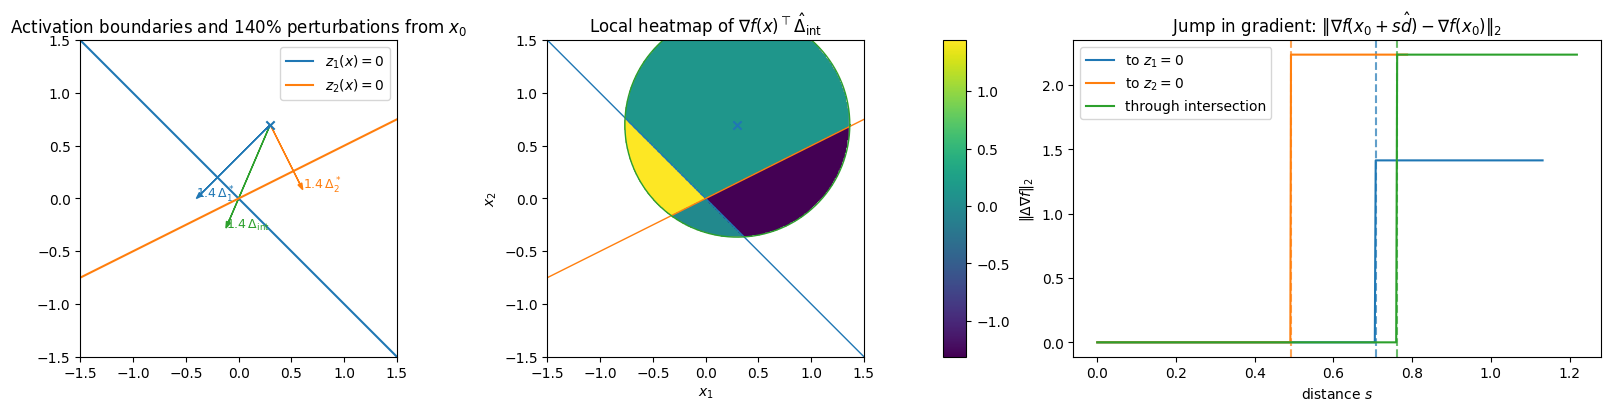

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ------------------------------------------------------------
# Create output directory for Lecture 5 figures
# ------------------------------------------------------------
os.makedirs("figs5", exist_ok=True)

# ------------------------------------------------------------
# Define the explicit ReLU toy model
#
#   f(x) = w^T ReLU(Ax)
#
# with pre-activations z(x) = Ax.
# ------------------------------------------------------------
A = np.array([[1., 1.],        # first pre-activation:  z1 = x1 + x2
              [-1., 2.]])      # second pre-activation: z2 = -x1 + 2x2
w = np.array([1., -1.])

def z(x):
    """Compute the vector of pre-activations z(x) = A x."""
    return A @ x

def grad_f(x):
    """
    Compute the gradient of f with respect to x.

    Since the network is piecewise linear, the gradient is
    constant within each activation region and depends only
    on which pre-activations are positive.
    """
    zz = z(x)
    D = (zz > 0).astype(float)      # ReLU derivative: 1 if active, 0 if inactive
    return (w * D) @ A              # row vector in R^2

def proj_to_boundary(x, a):
    """
    Project x onto the hyperplane {a^T x = 0}.

    This gives the minimum-norm correction needed to cross
    the corresponding activation boundary.
    """
    return x - (a @ x) / (a @ a) * a

def unit(v):
    """Return the unit vector in the direction of v."""
    n = np.linalg.norm(v)
    if n == 0:
        raise ValueError("Zero vector encountered.")
    return v / n

# ------------------------------------------------------------
# Choose evaluation point x0
#
# This point lies above the intersection of the two activation
# boundaries, with both ReLU units active.
# ------------------------------------------------------------
x0 = np.array([0.3, 0.7])

# Sanity check: both pre-activations should be positive
z0 = z(x0)
print("x0:", x0, "z(x0):", z0)

# ------------------------------------------------------------
# Define normals for the two activation boundaries
#
#   z1(x) = a1^T x = 0
#   z2(x) = a2^T x = 0
# ------------------------------------------------------------
a1 = A[0]
a2 = A[1]

# ------------------------------------------------------------
# Minimum-norm perturbations to each boundary
#
# Delta1 : smallest step from x0 to z1=0
# Delta2 : smallest step from x0 to z2=0
# Delta_int : step directly to the intersection (origin)
# ------------------------------------------------------------
Delta1 = proj_to_boundary(x0, a1) - x0
Delta2 = proj_to_boundary(x0, a2) - x0
Delta_int = -x0

# Scale perturbations to 140% so they visibly cross boundaries
scale = 1.4
V1 = scale * Delta1
V2 = scale * Delta2
V3 = scale * Delta_int

# ------------------------------------------------------------
# Define the activation boundary lines for plotting
#
#   z1(x)=0  => x2 = -x1
#   z2(x)=0  => x2 = 0.5 x1
# ------------------------------------------------------------
xx = np.linspace(-1.5, 1.5, 500)
y_z1 = -xx
y_z2 = 0.5 * xx

# ------------------------------------------------------------
# Figure layout:
#
#   [ Left pane | Middle pane | Colorbar | Right pane ]
#
# The dedicated colorbar axis prevents the middle pane
# from being squeezed horizontally.
# ------------------------------------------------------------
fig = plt.figure(figsize=(16, 4), constrained_layout=True)
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 0.05, 1.15])

ax0 = fig.add_subplot(gs[0, 0])   # boundaries + vectors
ax1 = fig.add_subplot(gs[0, 1])   # local heatmap
cax = fig.add_subplot(gs[0, 2])   # colorbar axis
ax2 = fig.add_subplot(gs[0, 3])   # jump plots

# ============================================================
# LEFT PANE: activation boundaries and perturbation vectors
# ============================================================
ax0.plot(xx, y_z1, label=r"$z_1(x)=0$")
ax0.plot(xx, y_z2, label=r"$z_2(x)=0$")
ax0.scatter(x0[0], x0[1], marker="x", zorder=5)

def draw_vec(ax, v, label, color):
    """
    Draw an arrow starting at x0 in direction v, with a label.
    """
    ax.arrow(
        x0[0], x0[1], v[0], v[1],
        head_width=0.04,
        length_includes_head=True,
        color=color
    )
    ax.text(
        x0[0] + v[0], x0[1] + v[1],
        label, fontsize=9, color=color
    )

draw_vec(ax0, V1, r"$1.4\,\Delta_1^*$", "C0")
draw_vec(ax0, V2, r"$1.4\,\Delta_2^*$", "C1")
draw_vec(ax0, V3, r"$1.4\,\Delta_{\mathrm{int}}$", "C2")

ax0.set_title("Activation boundaries and 140% perturbations from $x_0$")
ax0.set_aspect("equal")
ax0.set_xlim(-1.5, 1.5)
ax0.set_ylim(-1.5, 1.5)
ax0.legend()

# ============================================================
# MIDDLE PANE: gradient heatmap in a circular neighborhood
# ============================================================

# Radius is chosen as the largest 140% perturbation
R = max(np.linalg.norm(V1), np.linalg.norm(V2), np.linalg.norm(V3))

# Direction used for the directional-derivative heatmap
d_heat = unit(Delta_int)

# Create a square grid
grid = 250
x1 = np.linspace(-1.5, 1.5, grid)
x2 = np.linspace(-1.5, 1.5, grid)
X1, X2 = np.meshgrid(x1, x2)

# Compute the directional derivative at each grid point
H = np.zeros_like(X1)
for i in range(grid):
    for j in range(grid):
        x = np.array([X1[i, j], X2[i, j]])
        H[i, j] = grad_f(x) @ d_heat

# Mask everything outside the circular neighborhood
mask = (X1 - x0[0])**2 + (X2 - x0[1])**2 > R**2
H = np.ma.array(H, mask=mask)

# Plot the heatmap
im = ax1.imshow(
    H,
    extent=[x1.min(), x1.max(), x2.min(), x2.max()],
    origin="lower",
    aspect="equal"
)

# Overlay boundary lines and neighborhood circle
xx_local = np.linspace(x1.min(), x1.max(), 400)
ax1.plot(xx_local, -xx_local, linewidth=1)
ax1.plot(xx_local, 0.5 * xx_local, linewidth=1)

theta = np.linspace(0, 2*np.pi, 400)
ax1.plot(x0[0] + R*np.cos(theta), x0[1] + R*np.sin(theta), linewidth=1)

ax1.scatter(x0[0], x0[1], marker="x", zorder=5)
ax1.set_title(r"Local heatmap of $\nabla f(x)^\top \hat{\Delta}_{\mathrm{int}}$")
ax1.set_xlabel(r"$x_1$")
ax1.set_ylabel(r"$x_2$")
ax1.set_aspect("equal")
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)

# Dedicated colorbar so the middle pane keeps full width
fig.colorbar(im, cax=cax)

# ============================================================
# RIGHT PANE: jumps in the differential explanation
# ============================================================

# Baseline gradient at x0
g0 = grad_f(x0)

def plot_jump_curve(ax, Delta, label, color):
    """
    Plot the magnitude of the change in gradient along the
    unit direction associated with Delta.
    """
    d = unit(Delta)
    s_star = np.linalg.norm(Delta)          # boundary crossing distance
    s = np.linspace(0.0, 1.6 * s_star, 500)

    vals = np.array([
        np.linalg.norm(grad_f(x0 + si * d) - g0)
        for si in s
    ])

    ax.plot(s, vals, label=label, color=color)
    ax.axvline(s_star, linestyle="--", color=color, alpha=0.7)

plot_jump_curve(ax2, Delta1, r"to $z_1=0$", "C0")
plot_jump_curve(ax2, Delta2, r"to $z_2=0$", "C1")
plot_jump_curve(ax2, Delta_int, r"through intersection", "C2")

ax2.set_title(r"Jump in gradient: $\|\nabla f(x_0+s\hat d)-\nabla f(x_0)\|_2$")
ax2.set_xlabel("distance $s$")
ax2.set_ylabel(r"$\|\Delta \nabla f\|_2$")
ax2.legend()

# ------------------------------------------------------------
# Save figure
# ------------------------------------------------------------
outpath = "figs5/relu_boundary_custom_three_panes.png"
plt.savefig(outpath, dpi=200, bbox_inches="tight")

print("Saved", outpath)

## SmoothGrad and VarGrad on ReLU model

x0: [0.3 0.7] z(x0): [1.  1.1]


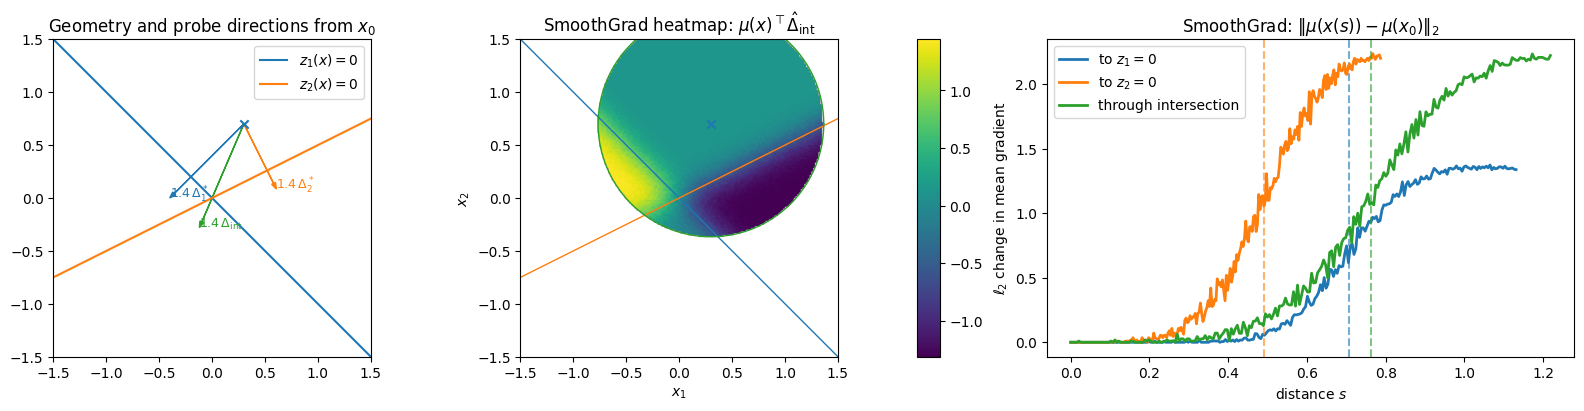

Saved figs5/relu_smoothgrad.png


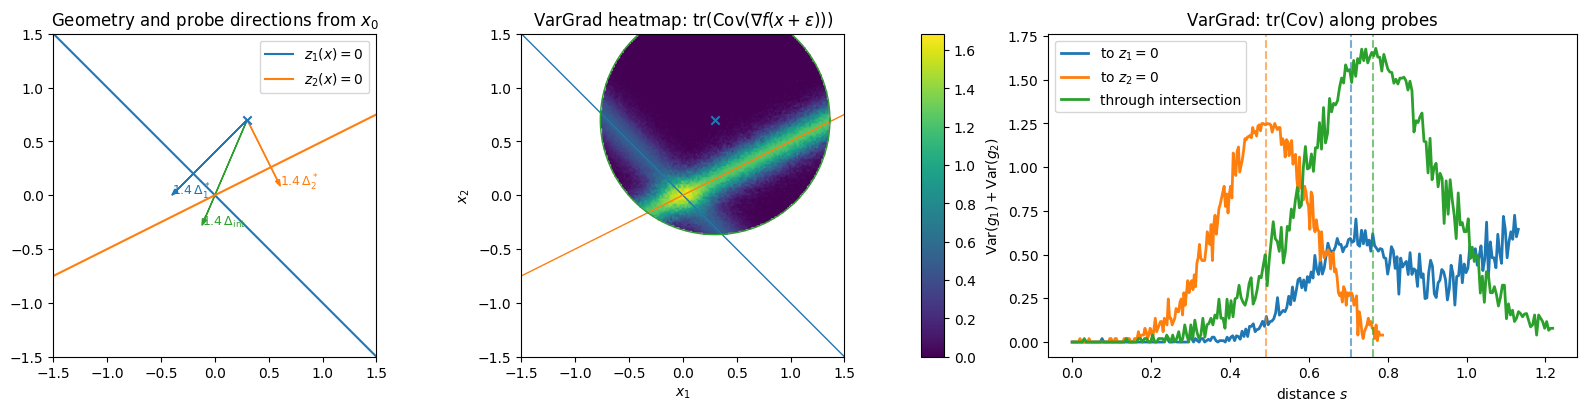

Saved figs5/relu_vargrad.png
Params: N=250, sigma=0.1279 (sigma/R=0.120)


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

# ------------------------------------------------------------
# Output directory
# ------------------------------------------------------------

os.makedirs("figs5", exist_ok=True)

# ------------------------------------------------------------
# Explicit ReLU toy model
#
#   f(x) = w^T ReLU(Ax)
# ------------------------------------------------------------

A = np.array([[1., 1.],
              [-1., 2.]])
w = np.array([1., -1.])

# Compute pre-activations z(x) = A x
def z(x):
    return A @ x

# Compute ∇_x f(x) (piecewise constant)
def grad_f(x):
    zz = z(x)
    # ReLU derivative: 1 if active, 0 if inactive
    D = (zz > 0).astype(float)
    # Chain rule: w^T diag(D) A
    return (w * D) @ A

# Project x onto boundary {a^T x = 0}
def proj_to_boundary(x, a):
    return x - (a @ x) / (a @ a) * a

# Normalize vector
def unit(v):
    n = np.linalg.norm(v)
    if n == 0:
        raise ValueError("Zero vector encountered.")
    return v / n

# ------------------------------------------------------------
# Evaluation point and probe directions
# ------------------------------------------------------------

x0 = np.array([0.3, 0.7])
print("x0:", x0, "z(x0):", z(x0))

# Boundary normals are rows of A
a1 = A[0]
a2 = A[1]

# Minimum-norm perturbations to boundaries / intersection
Delta1 = proj_to_boundary(x0, a1) - x0
Delta2 = proj_to_boundary(x0, a2) - x0
Delta_int = -x0

# Scale perturbations so arrows cross boundaries
scale = 1.4
V1 = scale * Delta1
V2 = scale * Delta2
V3 = scale * Delta_int

# Neighborhood radius for the heatmap mask
R = max(np.linalg.norm(V1), np.linalg.norm(V2), np.linalg.norm(V3))

# ------------------------------------------------------------
# SmoothGrad / VarGrad configuration
# ------------------------------------------------------------

# Number of noise samples
N = 250

# Noise scale relative to neighborhood radius
sigma = 0.12 * R

# RNG for reproducibility
rng = np.random.default_rng(0)

# Estimate μ(x) = E[∇f(x+ε)]
def smoothgrad_mu(x, N, sigma):
    # Sample isotropic Gaussian noise
    eps = rng.normal(0.0, sigma, size=(N, 2))
    # Compute gradients at perturbed points
    grads = np.array([grad_f(x + e) for e in eps])
    # Return mean gradient vector
    return grads.mean(axis=0)

# Estimate VarGrad magnitude tr(Cov(∇f(x+ε)))
def vargrad_mag(x, N, sigma):
    # Sample isotropic Gaussian noise
    eps = rng.normal(0.0, sigma, size=(N, 2))
    # Compute gradients at perturbed points
    grads = np.array([grad_f(x + e) for e in eps])
    # Return Var(g1)+Var(g2)
    return grads.var(axis=0).sum()

# ------------------------------------------------------------
# Shared plotting helpers
# ------------------------------------------------------------

# Boundary lines for plotting
xx = np.linspace(-1.5, 1.5, 600)
y_z1 = -xx
y_z2 = 0.5 * xx

# Heatmap direction (through the intersection)
d_heat = unit(Delta_int)

# Draw geometry and probe directions
def draw_geometry(ax):
    # Plot activation boundaries
    ax.plot(xx, y_z1, label=r"$z_1(x)=0$")
    ax.plot(xx, y_z2, label=r"$z_2(x)=0$")

    # Mark x0
    ax.scatter(x0[0], x0[1], marker="x", zorder=5)

    # Arrow helper
    def draw_vec(v, label, color):
        ax.arrow(
            x0[0], x0[1], v[0], v[1],
            head_width=0.04,
            length_includes_head=True,
            color=color
        )
        ax.text(x0[0] + v[0], x0[1] + v[1], label, fontsize=9, color=color)

    # Show probe directions
    draw_vec(V1, r"$1.4\,\Delta_1^*$", "C0")
    draw_vec(V2, r"$1.4\,\Delta_2^*$", "C1")
    draw_vec(V3, r"$1.4\,\Delta_{\mathrm{int}}$", "C2")

    # Axes formatting
    ax.set_aspect("equal")
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.legend()

# Create a masked grid over the neighborhood ball
def make_masked_grid(grid=180):
    # Grid coordinates
    x1 = np.linspace(-1.5, 1.5, grid)
    x2 = np.linspace(-1.5, 1.5, grid)
    X1, X2 = np.meshgrid(x1, x2)

    # Mask outside radius R centered at x0
    mask = (X1 - x0[0])**2 + (X2 - x0[1])**2 > R**2

    return x1, x2, X1, X2, mask

# ------------------------------------------------------------
# FIGURE 1: SmoothGrad
# ------------------------------------------------------------

# Layout: [ geometry | heatmap | colorbar | 1D curves ]
fig = plt.figure(figsize=(16, 4), constrained_layout=True)
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 0.05, 1.15])

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
cax = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[0, 3])

# Left pane: geometry
draw_geometry(ax0)
ax0.set_title("Geometry and probe directions from $x_0$")

# Middle pane: H_SG(x) = μ(x)^T d_heat
x1, x2, X1, X2, mask = make_masked_grid(grid=180)
H_sg = np.zeros_like(X1)

# Compute SmoothGrad directional field
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        x = np.array([X1[i, j], X2[i, j]])
        mu = smoothgrad_mu(x, N=N, sigma=sigma)
        H_sg[i, j] = mu @ d_heat

# Mask outside neighborhood
H_sg = np.ma.array(H_sg, mask=mask)

# Plot heatmap
im = ax1.imshow(
    H_sg,
    extent=[x1.min(), x1.max(), x2.min(), x2.max()],
    origin="lower",
    aspect="equal"
)

# Overlay boundaries
xx_local = np.linspace(x1.min(), x1.max(), 500)
ax1.plot(xx_local, -xx_local, linewidth=1)
ax1.plot(xx_local, 0.5 * xx_local, linewidth=1)

# Overlay neighborhood circle
theta = np.linspace(0, 2*np.pi, 400)
ax1.plot(x0[0] + R*np.cos(theta), x0[1] + R*np.sin(theta), linewidth=1)

# Mark x0
ax1.scatter(x0[0], x0[1], marker="x", zorder=5)

# Label axes
ax1.set_title(r"SmoothGrad heatmap: $\mu(x)^\top \hat{\Delta}_{\mathrm{int}}$")
ax1.set_xlabel(r"$x_1$")
ax1.set_ylabel(r"$x_2$")
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)

# Add colorbar
fig.colorbar(im, cax=cax)

# Right pane: ||μ(x(s)) - μ(x0)|| along probes
mu0 = smoothgrad_mu(x0, N=N, sigma=sigma)

def plot_sg(ax, Delta, label, color):
    # Unit direction for probe ray
    d = unit(Delta)
    # Boundary crossing distance
    s_star = np.linalg.norm(Delta)
    # Sample beyond crossing
    s = np.linspace(0.0, 1.6 * s_star, 240)

    # Allocate values
    sg_vals = np.zeros_like(s)

    for k, si in enumerate(s):
        # Point on probe ray
        x = x0 + si * d
        # SmoothGrad mean at x
        mu = smoothgrad_mu(x, N=N, sigma=sigma)
        # Change magnitude from x0
        sg_vals[k] = np.linalg.norm(mu - mu0)

    # Plot curve
    ax.plot(s, sg_vals, label=label, color=color, linewidth=2)
    # Mark crossing
    ax.axvline(s_star, linestyle="--", color=color, alpha=0.6)

plot_sg(ax2, Delta1, r"to $z_1=0$", "C0")
plot_sg(ax2, Delta2, r"to $z_2=0$", "C1")
plot_sg(ax2, Delta_int, r"through intersection", "C2")

ax2.set_title(r"SmoothGrad: $\|\mu(x(s)) - \mu(x_0)\|_2$")
ax2.set_xlabel("distance $s$")
ax2.set_ylabel(r"$\ell_2$ change in mean gradient")
ax2.legend(loc="upper left")

# Save figure
out_sg = "figs5/relu_smoothgrad.png"
fig.savefig(out_sg, dpi=200, bbox_inches="tight")

# Show figure in notebook
plt.show()

# Close to avoid accumulating figures
plt.close(fig)

print("Saved", out_sg)

# ------------------------------------------------------------
# FIGURE 2: VarGrad
# ------------------------------------------------------------

# Layout: [ geometry | heatmap | colorbar | 1D curves ]
fig = plt.figure(figsize=(16, 4), constrained_layout=True)
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 0.05, 1.15])

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
cax = fig.add_subplot(gs[0, 2])
ax2 = fig.add_subplot(gs[0, 3])

# Left pane: geometry
draw_geometry(ax0)
ax0.set_title("Geometry and probe directions from $x_0$")

# Middle pane: V_VG(x) = tr(Cov(∇f(x+ε)))
x1, x2, X1, X2, mask = make_masked_grid(grid=180)
H_vg = np.zeros_like(X1)

# Compute VarGrad magnitude field
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        x = np.array([X1[i, j], X2[i, j]])
        H_vg[i, j] = vargrad_mag(x, N=N, sigma=sigma)

# Mask outside neighborhood
H_vg = np.ma.array(H_vg, mask=mask)

# Plot heatmap
im = ax1.imshow(
    H_vg,
    extent=[x1.min(), x1.max(), x2.min(), x2.max()],
    origin="lower",
    aspect="equal"
)

# Overlay boundaries
xx_local = np.linspace(x1.min(), x1.max(), 500)
ax1.plot(xx_local, -xx_local, linewidth=1)
ax1.plot(xx_local, 0.5 * xx_local, linewidth=1)

# Overlay neighborhood circle
theta = np.linspace(0, 2*np.pi, 400)
ax1.plot(x0[0] + R*np.cos(theta), x0[1] + R*np.sin(theta), linewidth=1)

# Mark x0
ax1.scatter(x0[0], x0[1], marker="x", zorder=5)

# Label axes
ax1.set_title(r"VarGrad heatmap: $\mathrm{tr}(\mathrm{Cov}(\nabla f(x+\varepsilon)))$")
ax1.set_xlabel(r"$x_1$")
ax1.set_ylabel(r"$x_2$")
ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)

# Add colorbar
fig.colorbar(im, cax=cax)

# Right pane: VarGrad magnitude along probes
def plot_vg(ax, Delta, label, color):
    # Unit direction for probe ray
    d = unit(Delta)
    # Boundary crossing distance
    s_star = np.linalg.norm(Delta)
    # Sample beyond crossing
    s = np.linspace(0.0, 1.6 * s_star, 240)

    # Allocate values
    vg_vals = np.zeros_like(s)

    for k, si in enumerate(s):
        # Point on probe ray
        x = x0 + si * d
        # VarGrad magnitude at x
        vg_vals[k] = vargrad_mag(x, N=N, sigma=sigma)

    # Plot curve
    ax.plot(s, vg_vals, label=label, color=color, linewidth=2)
    # Mark crossing
    ax.axvline(s_star, linestyle="--", color=color, alpha=0.6)

plot_vg(ax2, Delta1, r"to $z_1=0$", "C0")
plot_vg(ax2, Delta2, r"to $z_2=0$", "C1")
plot_vg(ax2, Delta_int, r"through intersection", "C2")

ax2.set_title(r"VarGrad: $\mathrm{tr}(\mathrm{Cov})$ along probes")
ax2.set_xlabel("distance $s$")
ax2.set_ylabel(r"$\mathrm{Var}(g_1)+\mathrm{Var}(g_2)$")
ax2.legend(loc="upper left")

# Save figure
out_vg = "figs5/relu_vargrad.png"
fig.savefig(out_vg, dpi=200, bbox_inches="tight")

# Show figure in notebook
plt.show()

# Close to avoid accumulating figures
plt.close(fig)

print("Saved", out_vg)

# ------------------------------------------------------------
# Print parameters once
# ------------------------------------------------------------

print(f"Params: N={N}, sigma={sigma:.4f} (sigma/R={sigma/R:.3f})")
